https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/

Bagging classifiers is the best way to defeat over-fitting.

In [1]:
import matplotlib.pyplot as plt
import model.temporary.testing_k_folds as driver
from sklearn.metrics import confusion_matrix
import matplotlib as plt
import seaborn as sns

'''
- i = get classification probabilities
- determine the bins
- determine students that fit within their
respective bins
- determine those who are TP and FP
  (probably determined beforehand somehow)
- loop through student list, summing
  all the empirical risks and then getting
  the mean
- Plot

- The empirical risk curve will most likely
  not resemble the paper, so there might
  need to be changes.
'''

model_pipeline, X_test, y_test = driver.get_model_pipeline()
print('done')

Number of students on reduced lunch: 23
<class 'pandas.core.frame.DataFrame'>
Scoring used:  recall
Best parameters:  {}
Best/Mean score using best parameters:  0.41666666666666663
[[7 1]
 [1 7]]
Percentage:  0.875
16
done


In [2]:
class Bin:
    total_instances = 0
    real_positives = 0
    upper_range = 0
    lower_range = 0
    index = 0
    empirical_risk = 0

    def __init__(self, index, number_of_bins):
        ranges = 1 / number_of_bins
        self.upper_range = (index+1) * ranges
        self.lower_range = (self.upper_range - ranges) - 0.001
        self.index = index

    def add_student(self, is_real_positive):
        self.total_instances += 1

        if is_real_positive:
            self.real_positives += 1

        self.empirical_risk = self.real_positives / self.total_instances

Each bin object in the bins array will hold information regarding the
distribution of students. More than that, it will hold information regarding
the number of true positives out of the true positive and negatives.

In [3]:
number_of_bins_test = 4
bins_test = [Bin(x, number_of_bins_test)for x in range(0,number_of_bins_test)]

# Parameter: actual_positive encompasses false and true positives.
def add_to_bin(bin_array, probability, actual_positive):

    if probability > 1 or probability < 0:
        raise ValueError("Probability must be in range (0, 1)")
    
    for k in bin_array:
        #bins encompass values of lower range <= x < upper_range
        if probability < k.upper_range:
            k.add_student(actual_positive)
            return

        # special case where one's determined probability IS one
        if probability == 1 and k.upper_range == 1:
            k.add_student(actual_positive)
            return

    raise RuntimeError("Could not find bin for a student. Bin array was \
                       initialized wrongly")

add_to_bin(bins_test, 0.11, True)
add_to_bin(bins_test, 0.276, True)
add_to_bin(bins_test, 0.25, True)

assert bins_test[0].total_instances == 1
assert bins_test[1].total_instances == 2

In [4]:
import numpy as np

predictions = []
# contain student info and their probability in order to sort them
student_prediction_list = []
y_pred = [] #this is for the confusion matrix

print(type(X_test))
print(X_test.index)
print(X_test.iloc[1])
print(type(X_test.iloc[2]))

print(X_test.shape)


model_pipeline.predict(X_test.iloc[2].values.reshape(1,-1))

for i in range(X_test.shape[0]):
    student_data_point = X_test.iloc[i].values.reshape(1,-1)
    pred = model_pipeline.predict(student_data_point)
    y_pred_prob = model_pipeline.best_estimator_['model'].predict_proba(student_data_point)[:, 1]

    #whether a student was positive, regardless if false positive or true positive
    student_actually_positive = y_test.iloc[i] == True

    predictions.append({"prediction": pred[0],
                        "student_actually_positive": student_actually_positive,
                        "probability": y_pred_prob[0]})

    student_prediction_list.append({"student": student_data_point,
                                    "probability": y_pred_prob[0]})

    y_pred.append(pred)

matrix = confusion_matrix(y_test, np.asarray(y_pred).reshape(-1,1))
print(matrix)


#
number_of_bins = 4
#### INITIALIZING THE BIN ARRAY
bins = [Bin(x, number_of_bins)for x in range(0,number_of_bins)]

#COUNT NUMBER OF TRUE POSITIVES
count = 0
for i in predictions:
    if i['student_actually_positive']:
        count += 1

print(count)

for student_results in predictions:
    add_to_bin(bins, student_results['probability'], student_results['student_actually_positive'])

instances_count = 0
for i in bins:
    print("BIN %i" % i.index)
    instances_count += i.total_instances
    print("Instances: ", i.total_instances)
    print("Actual positives: ", i.real_positives)
    print("Empirical Risk of Bin: ", i.empirical_risk)

print(instances_count)

student_prediction_list.sort(key=lambda x: x["probability"])

# for student in student_prediction_list:
#     print(student["student"])
#     print(student["probability"])
#     print("======")
#

<class 'pandas.core.frame.DataFrame'>
Int64Index([68, 77, 44, 27, 63, 73, 61, 55, 51, 34, 38, 33, 10, 59, 36, 2], dtype='int64')
A8                                      13.0
Has_504_No                               1.0
Has_504_Yes                              0.0
Student on Free or Reduced Lunch_No      0.0
Student on Free or Reduced Lunch_Yes     1.0
IEP/Specialized_No                       1.0
IEP/Specialized_Yes                      0.0
Name: 77, dtype: float64
<class 'pandas.core.series.Series'>
(16, 7)
[[7 1]
 [1 7]]
8
BIN 0
Instances:  7
Actual positives:  1
Empirical Risk of Bin:  0.14285714285714285
BIN 1
Instances:  1
Actual positives:  0
Empirical Risk of Bin:  0.0
BIN 2
Instances:  4
Actual positives:  3
Empirical Risk of Bin:  0.75
BIN 3
Instances:  4
Actual positives:  4
Empirical Risk of Bin:  1.0
16


[0.14285714285714285, 0.0, 0.75, 1.0]


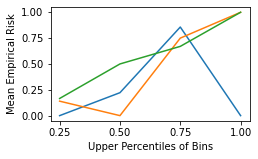

In [57]:
# Graphing mean empirical risk

y_values = [] # mean empirical risk of each bin
x_values = []
for i in bins:
    y_values.append(i.empirical_risk)
    x_values.append(i.upper_range)

print(y_values)

x_values = [0.25, 0.5, 0.75, 1]
y_values = [0, 0.222, 0.85714, 0]
# AdaBoost

# plt.pyplot.figure(figsize=(10,5))

ax = sns.lineplot(x=x_values, y=y_values)
ax.set_xlabel("Upper Percentiles of Bins")
ax.set_ylabel("Mean Empirical Risk")
ax.set_xticks([0.25, 0.5, 0.75, 1])

# Random Forest
y_values = [0.14, 0, 0.75, 1]
sns.lineplot(x=x_values, y=y_values)

# Linear Regression
y_values = [0.166, 0.5, 0.67, 1]
sns.lineplot(x=x_values, y=y_values)

fig = ax.get_figure()

width  = 3.5
height = width / 1.618
fig.subplots_adjust(left=.20, bottom=.24, right=.99, top=.97)
fig.set_size_inches(width, height)
fig.savefig('myimage.png')